
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    Shuyang Fan, Yiran Wang 

**Student ID(s):**     988301, 987751


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy.stats import mode 
from collections import Counter, defaultdict
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Read data from csv
def read_data(fileName):
    data = pd.read_csv(fileName, header=None)
    return data

In [3]:
def handle_missing_value(data):
    # Make a copy of raw data
    copy = data.copy()
    # Drop rows with question mark
    copy = copy[(copy.astype(str) != '?').all(axis=1)]
    copy = copy.dropna()
    copy = copy.reset_index(drop=True)
    return copy

In [4]:
def equal_width_binning(data, column_indexes, bin_num):
    copy = data.copy()
    for column in column_indexes:
        copy.iloc[:,column] = pd.cut(copy.iloc[:,column], bin_num)
    return copy

In [5]:
def equal_frequency_binning(data, column_indexes, bin_num):
    copy = data.copy()
    for column in column_indexes:
        copy.iloc[:,column] = pd.qcut(copy.iloc[:,column], bin_num)
    return copy

In [6]:
def kmeans_binning(data, column_indexes, k):
    copy = data.copy()
    for column in column_indexes:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(copy.iloc[:,column])
        copy.iloc[:,column] = kmeans.labels_
    return copy



In [7]:
#hold_out the training and test data in the ratio of 8:2    
def train_test_split(X, y, test_size=0.2):
    X_total = X.shape[0]
    assert(X_total == y.size)
    np.random.seed(42)
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, test_size*100)
    X_test = X[split]
    y_test = y[split]
    X_train =  X[~split]
    y_train = y[~split]
    return X_train, X_test, y_train, y_test



In [8]:
#Bayes calculate the product of prior and conditinoals,, take the max
#then predict, throw the X-test into the model
#then check the accuracy

In [9]:
def find_key_with_max_value(dic):
    max_value = -1e5
    max_key = None
    for key in dic:
        if dic[key] > max_value:
            max_key = key
            max_value = dic[key]
    return max_key
print(find_key_with_max_value({'<=50K': -15.768737460661638, '>50K': -18.479883639470405}))

<=50K


In [10]:
class BayesClassifier():

    def train(self, X_train, y_train, type_dict):
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        #extract the possible class labels from training data
        self.possible_labels = np.unique(self.y_train)
        #get the prior probability of training data
        self.prior = self.get_prior(self.y_train)
        self.type_dict = type_dict
        self.categorical_prob = self.compute_categorical(self.type_dict['nominal'],self.X_train, self.y_train)
        self.numeric_prob = self.compute_numeric(self.type_dict['numeric'], self.X_train, self.y_train)
    
    #function calculates the prior probability for all labels
    def get_prior(self, y_train):
        train_inputs = y_train
        #counts is a list that stores number of each label accordingly
        labels, counts = np.unique(train_inputs, return_counts=True)
        prior = {}
        for i, label in enumerate(labels):
            prior[label] = float(counts[i])/len(train_inputs)
        return prior      
    
    #function examines whether an attribute is numeric 
    def is_numeric_attribute(self, data, column_index):
        return is_numeric_dtype(data.iloc[:,column_index])

    #function that computes the conditional probability of categorical attribtues
    def compute_categorical(self, categorical_indexes, X_train, y_train):
        #create a dictionary to store results
        categorical_prob = defaultdict(lambda: defaultdict(dict))
        # Separate training instances by label
        grouped = X_train.groupby(y_train)
        
        for label in self.possible_labels:
            separated = grouped.get_group(label)
            #for each attribute in the same class
            for column_index in categorical_indexes:
                # Only process categorical attribute
                #if (self.is_numeric_attribute(X_train, column_index) == False):
                # Extract one attribute from group
                attribute = separated.iloc[:,column_index]
                total_rows = attribute.shape[0]
                # Find all possible values of this attribute
                possible_values = np.unique(X_train.iloc[:,column_index])
                # Call Counter to count the frequency of each value
                counts = Counter(attribute)
                for value in possible_values:
                    if value in counts:
                        categorical_prob[column_index][str(value)][label] = counts[value]/total_rows
        return categorical_prob
    
    #function calculated the conditional probability for numeric attribtues
    def compute_numeric(self, numeric_indexes, X_train, y_train):
        numeric_prob = defaultdict(lambda: defaultdict(dict))
        # Sepeate training instances by label
        grouped = X_train.groupby(y_train)
        
        for label in self.possible_labels:
            separated = grouped.get_group(label)
            for column_index in numeric_indexes:
                
                # if self.is_numeric_attribute(X_train, column_index):
                # Extract the attribute from group
                attribute = separated.iloc[:,column_index]
                # print(column_index, attribute)
                #calculate the mean and standard deviation of each attribute
                numeric_prob[column_index]['mean'][label] = attribute.mean()
                numeric_prob[column_index]['std'][label] = attribute.std()
                # print(label, column_index, numeric_prob[column_index]['std'][label])
        # print(numeric_prob)
        return numeric_prob
    
    
    def guassian(self, value, mean, stdev):
            exponent = math.exp(-((value-mean)**2 / (2 * stdev**2)))
            return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

    def predict(self, X_test):
        X_test_copy = X_test.copy()
        categorical_prob = self.categorical_prob
        numeric_prob = self.numeric_prob 
        priors = self.prior
        possible_labels = self.possible_labels
        predicted_outputs = []
    
        row, column = X_test_copy.shape
        for row_index in range(row):
            probability = defaultdict(float)
            
            for label in possible_labels:
                probability[label] = safe_log(priors[label])
                
            for column_index in range(column):
                # Get the value of this attribute
                value = X_test_copy.iloc[row_index, column_index]
                # Get conditional probability
                for label in possible_labels:
                    #calculate the numeric conditional probabily
                    if column_index in self.type_dict['numeric']:
                        #print("numeric",column_index)
                        try:
                            conditional_probability = self.guassian(value, numeric_prob[column_index]['mean'][label], numeric_prob[column_index]['std'][label])
                            probability[label] += safe_log(conditional_probability)

                        except ZeroDivisionError:
                            pass
                    elif column_index in self.type_dict['nominal']:
                        #print("nomial",column_index)
                        if label not in categorical_prob[column_index][str(value)]:
                            #assign a tiny probability to each event even if events are unlikely (epsilon smoothing)
                            conditional_probability = 1e-9
                        else:
                            conditional_probability = categorical_prob[column_index][str(value)][label]
                        #take the log of each probabilty and sum it
                        probability[label] += safe_log(conditional_probability)
            # The prediced outcome is the lebel with the highest probability
            predicted_outputs.append(find_key_with_max_value(probability))
        return predicted_outputs
    


def safe_log(x):
    if x <= 0:
        return 0
    return math.log(x)

In [11]:
def oridinal_to_integer(X, replacement_map):
    copy = X.copy()
    for column_index in replacement_map:
        map = {key:index for index, key in enumerate(replacement_map[column_index])}
        copy.iloc[:,column_index] = copy.iloc[:,column_index].map(map)
    return copy



In [12]:
def accuracy(y_predicted, y_truth):
    assert(y_predicted.size==y_truth.size)
    return np.sum(y_predicted == y_truth)/y_predicted.size

In [17]:
def build_type_dict(type_list, treat_ordinal_as):
    type_dict=defaultdict(list)
    for index, type in enumerate(type_list):
        if (type==0):
            type_dict["nominal"].append(index)
        elif type==1:
            type_dict[treat_ordinal_as].append(index)    
        else:
            type_dict["numeric"].append(index)
    return type_dict


In [18]:
def random_baseline(X_train, y_train):
    labels = np.unique(y_train)
    np.random.seed(42)
    y_baseline = np.array([np.random.choice(labels) for i in range(y_train.size)])
    return y_baseline

In [19]:
def zero_r_baseline(X_train, y_train):
    try:
        label = mode(y_train)
    except:
        print(y_train)
    return np.repeat(label.mode, y_train.size)

In [20]:
def label_confusion_matrix(y_predicted, y_truth, label):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for index in range(y_predicted.size):
        result =  y_predicted[index]
        if (result==label):
            if ((y_truth[index]) == label):
                TP +=1
            else:
                FP +=1
        else:
            if ((y_truth[index]) == label):
                FN += 1
            else:
                TN += 1
    return TP, TN, FP, FN
                
  
# (TP, TN, FP, FN) = label_confusion_matrix(np.array([1, 0, 0, 1, 2]), np.array([1, 0, 1, 0, 2]), 2)  
# print(TP, TN, FP, FN)  

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

1. Try discretising the numeric attributes in these datasets and treating them as discrete variables
in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the
numeric values into any number of levels (but around 3 to 5 levels would probably be a good
starting point). Does discretizing the variables improve classification performance, compared
to the Gaussian na¨ıve Bayes approach? Why or why not?

## wdbc

In [21]:
label_index = 1
data_set ="./datasets/wdbc.data"
data = pd.read_csv(data_set, header=None)

In [22]:
accuracy_dict = {"train_accuracy": [], "test_accuracy": [], "gaussian_accuracy": []}

y = data.iloc[:,label_index] 
X = data.drop(data.columns[label_index], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,2:],y, test_size=0.33)

bayes = BayesClassifier()
type_list = [2 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))
gaussian_result = bayes.predict(X_test)
gaussian_accuracy = accuracy(np.array(gaussian_result), np.array(y_test))


24


Text(0, 0.5, 'Accuracy')

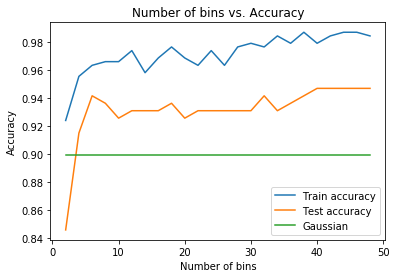

In [23]:
for i in range(2,50, 2):
    discretized_data = equal_width_binning(data, list(range(2,32)), i)
    y = discretized_data.iloc[:,label_index]  
    X_train, X_test, y_train, y_test = train_test_split(discretized_data.iloc[:,2:],y, test_size=0.33)
    bayes = BayesClassifier()
    type_list = [0 for i in range(X_train.shape[1])]
    bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))

    train_result = bayes.predict(X_train)
    accuracy_dict["train_accuracy"].append(accuracy(np.array(train_result), np.array(y_train)))
    test_result = bayes.predict(X_test)
    accuracy_dict["test_accuracy"].append(accuracy(np.array(test_result), np.array(y_test)))    
    # Add gaussian accuracy to draw a straight line
    accuracy_dict['gaussian_accuracy'].append(gaussian_accuracy)


print(len(accuracy_dict["test_accuracy"]))
bin_num_df = pd.DataFrame.from_dict(accuracy_dict)
bin_num_df.index = list(range(2,50, 2))
bin_num_df.columns = ['Train accuracy', 'Test accuracy', "Gaussian"]
bin_num_df.head()

plot = bin_num_df.plot(title='Number of bins vs. Accuracy')
plot.set_xlabel("Number of bins")
plot.set_ylabel("Accuracy")

## Wine

Text(0, 0.5, 'Accuracy')

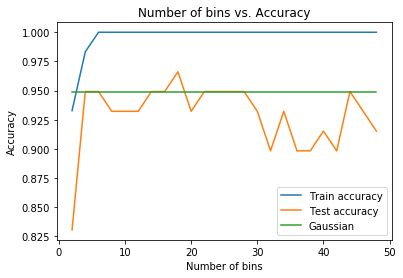

In [24]:
label_index = 0
data_set ="./datasets/wine.data"
data = pd.read_csv(data_set, header=None)
accuracy_dict = {"train_accuracy": [], "test_accuracy": [], "gaussian_accuracy": []}

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

bayes = BayesClassifier()
type_list = [2 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))
gaussian_result = bayes.predict(X_test)
gaussian_accuracy = accuracy(np.array(gaussian_result), np.array(y_test))

for i in range(2,50, 2):
    accuracy_dict['gaussian_accuracy'].append(gaussian_accuracy)

    
    discretized_data = equal_width_binning(data, list(range(1,14)), i)
    X = discretized_data.drop(data.columns[label_index], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

    bayes = BayesClassifier()
    type_list = [0 for i in range(X_train.shape[1])]
    bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))

    train_result = bayes.predict(X_train)
    accuracy_dict["train_accuracy"].append((accuracy(np.array(train_result), np.array(y_train))))
    
    test_result = bayes.predict(X_test)
    accuracy_dict["test_accuracy"].append(accuracy(np.array(test_result), np.array(y_test)))    
    

bin_num_df = pd.DataFrame.from_dict(accuracy_dict)
bin_num_df.index = list(range(2,50, 2))
bin_num_df.columns = ['Train accuracy', 'Test accuracy', "Gaussian"]
bin_num_df.head()


plot = bin_num_df.plot(title='Number of bins vs. Accuracy')
plot.set_xlabel("Number of bins")
plot.set_ylabel("Accuracy")

2. Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve
Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance
varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline
performance.

In [25]:
baseline_dict = {"bayes": [], "random": [], "zeroR": []}

# cancer

In [41]:
data_set ="./datasets/breast-cancer-wisconsin.data"
data = pd.read_csv(data_set, header=None)
data = handle_missing_value(data)
label_index = 10
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)
X = X.iloc[:,1:]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
bayes = BayesClassifier()
type_list = [0 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="nominal"))
NB_result = bayes.predict(X_test)
NB_accuracy = accuracy(np.array(NB_result), np.array(y_test))
ran_baseline = random_baseline(X_test, np.array(y_test))
zeror_baseline = zero_r_baseline(X_test, np.array(y_test))

baseline_dict["bayes"].append(NB_accuracy)
baseline_dict["random"].append(accuracy(ran_baseline, y_test))
baseline_dict["zeroR"].append(accuracy(zeror_baseline, y_test))

# wdbc

In [43]:
label_index = 1
data_set ="./datasets/wdbc.data"
data = pd.read_csv(data_set, header=None)
X = X.iloc[:,2:]
X.shape

(683, 7)

In [44]:

y = data.iloc[:,label_index] 
X = data.drop(data.columns[label_index], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,2:],y, test_size=0.33)

bayes = BayesClassifier()
type_list = [2 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))
gaussian_result = bayes.predict(X_test)
gaussian_accuracy = accuracy(np.array(gaussian_result), np.array(y_test))
ran_baseline = random_baseline(X_test, np.array(y_test))
zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
baseline_dict["bayes"].append(gaussian_accuracy)
baseline_dict["random"].append(accuracy(ran_baseline, y_test))
baseline_dict["zeroR"].append(accuracy(zeror_baseline, y_test))

# Nursery

In [45]:
label_index = 8
data_set ="./datasets/nursery.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)
replacement_map = {
    0: ["usual", "pretentious", "great_pret"],
    1: ["proper", "less_proper", "improper", "critical", "very_crit"],
    2: ["complete", "completed", "incomplete", "foster"],
    3: ["1", "2","3", "more"],
    4: ["convenient", "less_conv", "critical"],
    5: ["convenient", "inconv"],
    6: ["nonprob", "slightly_prob", "problematic"],
    7: ["recommended", "priority", "not_recom"],
}

In [46]:
last = np.unique(X.iloc[:,-1])
last

array(['not_recom', 'priority', 'recommended'], dtype=object)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()

#consider all the ordinal attributes as nominal
type_list_nominal = [0 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list_nominal, treat_ordinal_as="numeric"))
nominal_result = bayes.predict(X_test)

print("treat ordinal as nominal naive bayes result:",accuracy(np.array(nominal_result), np.array(y_test)))


ran_baseline = random_baseline(X_test, np.array(y_test))
print("random baseline result:", accuracy(ran_baseline, y_test))

zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
print("zeroR baseline result:", accuracy(zeror_baseline, y_test))
baseline_dict["bayes"].append(accuracy(np.array(nominal_result), np.array(y_test)))
baseline_dict["random"].append(accuracy(ran_baseline, y_test))
baseline_dict["zeroR"].append(accuracy(zeror_baseline, y_test))

treat ordinal as nominal naive bayes result: 0.9147376543209876
random baseline result: 0.2569444444444444
zeroR baseline result: 0.34915123456790126


# Adult

In [48]:
label_index = 14
data_set ="./datasets/adult.data"

In [49]:
data = pd.read_csv(data_set, header=None)
data = handle_missing_value(data)

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)



In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()
type_list = [2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0]
bayes.train(X_train, y_train, build_type_dict(type_list, "nominal"))

result = bayes.predict(X_test)

print(accuracy(np.array(result), np.array(y_test)))

ran_baseline = random_baseline(X_test, np.array(y_test))
print(accuracy(ran_baseline, y_test))

zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
print(accuracy(zeror_baseline, y_test))
baseline_dict["bayes"].append(accuracy(np.array(result), np.array(y_test)))
baseline_dict["random"].append(accuracy(ran_baseline, y_test))
baseline_dict["zeroR"].append(accuracy(zeror_baseline, y_test))


0.8188297696005304
0.490137576661694
0.7493784186971656


In [51]:
baseline_df = pd.DataFrame.from_dict(baseline_dict)

baseline_df.index = ['cancer',"wdbc","nursery","adult"]


plot = baseline_df.plot.bar()

plot.set_xlabel("Dataset")
plot.set_ylabel("Accuracy")

ValueError: Length mismatch: Expected axis has 7 elements, new values have 4 elements

3. Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as
either nominal variables or numeric variables. Compare these strategies on the ordinal datasets
provided. Deterimine which approach gives higher classification accuracy and discuss why.

In [52]:
ordinal_dict = {"nominal":[], "numeric": [], "random":[], "zeroR":[]}
def ordinal_handling(ordinal_dict, nominal_acc, numeric_acc, random_acc, zeroR_acc):
    ordinal_dict["nominal"].append(nominal_acc)
    ordinal_dict["numeric"].append(numeric_acc)
    ordinal_dict["random"].append(random_acc)
    ordinal_dict["zeroR"].append(zeroR_acc)
    return ordinal_dict
    

# Nursery

In [53]:
label_index = 8
data_set ="./datasets/nursery.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)
replacement_map = {
    0: ["usual", "pretentious", "great_pret"],
    1: ["proper", "less_proper", "improper", "critical", "very_crit"],
    2: ["complete", "completed", "incomplete", "foster"],
    3: ["1", "2","3", "more"],
    4: ["convenient", "less_conv", "critical"],
    5: ["convenient", "inconv"],
    6: ["nonprob", "slightly_prob", "problematic"],
    7: ["recommended", "priority", "not_recom"],
}

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()

#consider all the ordinal attributes as nominal
type_list_nominal = [0 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list_nominal,treat_ordinal_as="nominal" ))
nominal_result = bayes.predict(X_test)

print("treat ordinal as nominal naive bayes result:",accuracy(np.array(nominal_result), np.array(y_test)))


treat ordinal as nominal naive bayes result: 0.9147376543209876


In [55]:


X_numeric = oridinal_to_integer(X, replacement_map)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y)
bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list_numeric,treat_ordinal_as="numeric"))
numeric_result = bayes.predict(X_test)

print("treat ordinal as numeric naive bayes result:",accuracy(np.array(numeric_result), np.array(y_test)))

ran_baseline = random_baseline(X_test, np.array(y_test))
print("random baseline result:", accuracy(ran_baseline, y_test))

zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
print("zeroR baseline result:", accuracy(zeror_baseline, y_test))

NameError: name 'type_list_numeric' is not defined

In [56]:
ordinal_dic = ordinal_handling(ordinal_dict, accuracy(np.array(nominal_result), np.array(y_test)), accuracy(np.array(numeric_result), np.array(y_test)), accuracy(ran_baseline, y_test), accuracy(zeror_baseline, y_test))

NameError: name 'numeric_result' is not defined

# Somervillie

In [ ]:
label_index = 0
data_set ="./datasets/somerville.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()

#consider all the ordinal attributes as nominal
type_list_nominal = [0 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list_nominal,treat_ordinal_as="nominal" ))
nominal_result = bayes.predict(X_test)

print("treat ordinal as nominal naive bayes result:",accuracy(np.array(nominal_result), np.array(y_test)))



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y)
bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list_numeric,treat_ordinal_as="numeric"))
numeric_result = bayes.predict(X_test)

print("treat ordinal as numeric naive bayes result:",accuracy(np.array(numeric_result), np.array(y_test)))

ran_baseline = random_baseline(X_test, np.array(y_test))
print("random baseline result:", accuracy(ran_baseline, y_test))

zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
print("zeroR baseline result:", accuracy(zeror_baseline, y_test))

In [ ]:
ordinal_dic = ordinal_handling(ordinal_dict, accuracy(np.array(nominal_result), np.array(y_test)), accuracy(np.array(numeric_result), np.array(y_test)), accuracy(ran_baseline, y_test), accuracy(zeror_baseline, y_test))

# car

In [ ]:
label_index = 6
data_set ="./datasets/car.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

type_list_numeric = [2 for i in range(X.shape[1])]

replacement_map = {
    0: ["low", "med", "high", "vhigh"],
    1: ["low", "med", "high", "vhigh"],
    2: ["2", "3", "4", "5more"],
    3: ["2", "4", "more"],
    4: ["small", "med", "big"],
    5: ["low", "med", "high"]
}

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()

#consider all the ordinal attributes as nominal
type_list_nominal = [0 for i in range(X_train.shape[1])]
bayes.train(X_train, y_train, build_type_dict(type_list_nominal,treat_ordinal_as="nominal" ))
nominal_result = bayes.predict(X_test)

print("treat ordinal as nominal naive bayes result:",accuracy(np.array(nominal_result), np.array(y_test)))


In [ ]:
X_numeric = oridinal_to_integer(X, replacement_map)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y)
bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list_numeric,treat_ordinal_as="numeric"))
numeric_result = bayes.predict(X_test)

print("treat ordinal as numeric naive bayes result:",accuracy(np.array(numeric_result), np.array(y_test)))

ran_baseline = random_baseline(X_test, np.array(y_test))
print("random baseline result:", accuracy(ran_baseline, y_test))

zeror_baseline = zero_r_baseline(X_test, np.array(y_test))
print("zeroR baseline result:", accuracy(zeror_baseline, y_test))

In [ ]:
ordinal_dic = ordinal_handling(ordinal_dict, accuracy(np.array(nominal_result), np.array(y_test)), accuracy(np.array(numeric_result), np.array(y_test)), accuracy(ran_baseline, y_test), accuracy(zeror_baseline, y_test))

In [ ]:
ordinal_df = pd.DataFrame.from_dict(ordinal_dic)
ordinal_df.index = ['nursery',"somerville","car"]


plot = ordinal_df.plot.bar()

plot.set_xlabel("Dataset")
plot.set_ylabel("Accuracy")

4. Evaluating the model on the same data that we use to train the model is considered to be a major
mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy
(you should implement this yourself and do not simply call existing implementations from
scikit-learn). How does your estimate of effectiveness change, compared to testing on
the training data? Explain why. (The result might surprise you!)

## Wine

In [ ]:
label_index = 0
data_set ="./datasets/wine.data"
data = pd.read_csv(data_set, header=None)
accuracy_dict = {"hold-out": [], "all": []}

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
type_list = [2 for i in range(X_train.shape[1])]

bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="numeric"))
hold_out_result = bayes.predict(X_test)
accuracy_dict["hold-out"].append(accuracy(np.array(hold_out_result), np.array(y_test)))

bayes = BayesClassifier()
bayes.train(X, y, build_type_dict(type_list, treat_ordinal_as="numeric"))
all_result = bayes.predict(X)
accuracy_dict["all"].append(accuracy(np.array(all_result), np.array(y)))

## Nursery

In [ ]:
label_index = 8
data_set ="./datasets/nursery.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)
replacement_map = {
    0: ["usual", "pretentious", "great_pret"],
    1: ["proper", "less_proper", "improper", "critical", "very_crit"],
    2: ["complete", "completed", "incomplete", "foster"],
    3: ["1", "2","3", "more"],
    4: ["convenient", "less_conv", "critical"],
    5: ["convenient", "inconv"],
    6: ["nonprob", "slightly_prob", "problematic"],
    7: ["recommended", "priority", "not_recom"],
}

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
type_list_nominal = [0 for i in range(X_train.shape[1])]

bayes = BayesClassifier()
#consider all the ordinal attributes as nominal
bayes.train(X_train, y_train, build_type_dict(type_list_nominal, treat_ordinal_as="nominal"))
hold_out_result = bayes.predict(X_test)
accuracy_dict["hold-out"].append(accuracy(np.array(hold_out_result), np.array(y_test)))

bayes = BayesClassifier()
#consider all the ordinal attributes as nominal
bayes.train(X, y, build_type_dict(type_list_nominal, treat_ordinal_as="nominal"))
all_result = bayes.predict(X)
accuracy_dict["all"].append(accuracy(np.array(all_result), np.array(y)))

## Adult

In [ ]:
label_index = 14
data_set ="./datasets/adult.data"
data = pd.read_csv(data_set, header=None)
data = handle_missing_value(data)

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)
type_list = [2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
# result = random_baseline(X_test, y_test)

bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="nominal"))
hold_out_result = bayes.predict(X_test)
accuracy_dict["hold-out"].append(accuracy(np.array(hold_out_result), np.array(y_test)))

bayes = BayesClassifier()
bayes.train(X, y, build_type_dict(type_list, treat_ordinal_as="nominal"))
all_result = bayes.predict(X)
accuracy_dict["all"].append(accuracy(np.array(all_result), np.array(y)))

## Mushroom

In [ ]:
data_set ="./datasets/mushroom.data"
data = read_data(data_set)

data = handle_missing_value(data)

label_index = 0
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

type_list = [0 for i in range(X_train.shape[1])]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list, treat_ordinal_as="nominal"))
hand_out_result = bayes.predict(X_test)
accuracy_dict["hold-out"].append(accuracy(np.array(hand_out_result), np.array(y_test)))

bayes = BayesClassifier()
bayes.train(X, y, build_type_dict(type_list, treat_ordinal_as="nominal"))
all_result = bayes.predict(X)
accuracy_dict["all"].append(accuracy(np.array(all_result), np.array(y)))

## Car

In [ ]:
label_index = 6
data_set ="./datasets/car.data"
data = pd.read_csv(data_set, header=None)
y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

type_list_numeric = [2 for i in range(X.shape[1])]

replacement_map = {
    0: ["low", "med", "high", "vhigh"],
    1: ["low", "med", "high", "vhigh"],
    2: ["2", "3", "4", "5more"],
    3: ["2", "4", "more"],
    4: ["small", "med", "big"],
    5: ["low", "med", "high"]
}

y = data.iloc[:,label_index]  
X = data.drop(data.columns[label_index], axis=1, inplace=False)

X_numeric = oridinal_to_integer(X, replacement_map)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y)
bayes = BayesClassifier()
bayes.train(X_train, y_train, build_type_dict(type_list_numeric,treat_ordinal_as="numeric"))
hold_out_result = bayes.predict(X_test)
accuracy_dict["hold-out"].append(accuracy(np.array(hold_out_result), np.array(y_test)))

#consider all the ordinal attributes as numeric
bayes.train(X_numeric, y, build_type_dict(type_list_numeric,treat_ordinal_as="numeric"))
all_result = bayes.predict(X_numeric)
accuracy_dict["all"].append(accuracy(np.array(all_result), np.array(y)))


## Draw

In [ ]:
bin_num_df = pd.DataFrame.from_dict(accuracy_dict)
bin_num_df.index = ["wine", "nursery", "adult", "mushroom", "car"]
bin_num_df["diff"] = bin_num_df["all"] - bin_num_df["hold-out"]
bin_num_df.columns = ["hold-out", "all", "diff"]
bin_num_df.head()

In [ ]:
plot = bin_num_df.loc[:,["hold-out", "all"]].plot.bar(rot=0)
plot.set_ylim([0.7,1])
plot.set_xlabel("Dataset")
plot.set_ylabel("Accuracy")